In [1]:
# 최적의 모델을 얻고 싶을 경우, 세션 재시작 후 CPU 코어 7개로 설정.
import warnings
warnings.filterwarnings('ignore')

In [1]:
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import ResNet101, ResNet152

In [3]:
def seed_everything(seed=42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    tf.keras.utils.set_random_seed(seed)
    tf.keras.backend.clear_session()
    
seed_everything()

In [4]:
DATA_PATH = os.getcwd()
DATA_PATH

'/home/work/KISTI_PCB2'

In [5]:
# 중앙집중형
# All Data : PCB_CLF,
# client 1 : C1_PCB_CLF
# client 2 : C2_PCB_CLF
client = 'C2_PCB_CLF'

data_dir = os.path.join(DATA_PATH, f'{client}/')
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

In [6]:
image_size = (416, 416)

def load_images_and_labels(directory, image_size):
    
    labels = []
    images = []
    class_names = ['BADPCB', 'GOODPCB']
    
    for image_name in os.listdir(directory):

        image_path = os.path.join(directory, image_name)
        
        if 'ipynb_checkpoint' in image_path:
            continue
        
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
        image = tf.keras.preprocessing.image.img_to_array(image)
        images.append(image)
        
        # 파일 이름에 'GOODPCB'가 포함되어 있는지 확인
        if 'GOODPCB' in image_name:
            label = 1
        else:
            label = 0
        
        # 레이블과 이미지를 각각의 리스트에 추가
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels, class_names
    
train_images, train_labels, class_names = load_images_and_labels(train_dir, image_size)
test_images, test_labels, class_names =  load_images_and_labels(test_dir, image_size)

In [7]:
print(len(train_labels[train_labels == 0]), len(train_labels[train_labels == 1]))
print(len(test_labels[test_labels == 0]), len(test_labels[test_labels == 1]))

218 246
49 9


In [8]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)
print(class_names)

(464, 416, 416, 3) (464,)
(58, 416, 416, 3) (58,)
['BADPCB', 'GOODPCB']


In [9]:
print(np.min(train_images), np.max(train_images))
print(np.min(test_images), np.max(test_images))

0.0 255.0
0.0 255.0


## Stratified K-Fold (Train-Validation-Test)

In [10]:
from sklearn.model_selection import StratifiedKFold
ACCURACY = []
LOSS = []
val_acc = 0
fold_var = 1 # weight & model number
epochs = 300
best_model_accuracy = float("-inf")
best_model_loss = float("inf")
k = 3
batch_size = 8

skf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
for train_index, val_index in skf.split(train_images, train_labels):
    X_train = train_images[train_index] # train data
    y_train = train_labels[train_index]
    X_val = train_images[val_index] # valid data
    y_val = train_labels[val_index]
    
    
    # ResNet50 사용 or ResNet101 or Resnet152
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
    # 기존 CNN 모델에서의 Fully Connected 레이어 대신 Global Average Pooling 레이어 사용
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
#     x = Dense(512, activation='relu')(x)
#     x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint_path = f"./model_save_{client}/weight_" + str(fold_var) + ".ckpt"
    modelcheckpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True,
                                      save_weights_only=True)
    # learning rate scheduler
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
    earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]
    
   # FIT THE MODEL
    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_val, y_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callbacks_list  # Early Stopping 콜백 추가
                       )
    
    model.load_weights(checkpoint_path)
    model_path = f"./model_save_{client}/model_" + str(fold_var) + ".h5"
    model.save(model_path)
    
    results = model.evaluate(X_val, y_val, verbose=2)
    results = dict(zip(model.metrics_names, results))
 

    if results['accuracy'] > best_model_accuracy:
        best_model_accuracy = results['accuracy']
        best_model_loss = results['loss']
        best_history = history
        best_model = f'./model_save_{client}/model_' + f'{fold_var}.h5'  
    elif (results['accuracy'] == best_model_accuracy) and (best_model_loss > results['loss']):
        best_model_accuracy = results['accuracy']
        best_model_loss = results['loss']
        best_history = history
        best_model = f'./model_save_{client}/model_' + f'{fold_var}.h5'  
    
    ACCURACY.append(results['accuracy'])
    LOSS.append(results['loss'])
 
    tf.keras.backend.clear_session() ########
 
    fold_var += 1
 
    val_acc += results['accuracy']/k # 평균 Acc
    
print(val_acc)

Epoch 1/300
39/39 [==============================] - 24s 297ms/step - loss: 0.3450 - accuracy: 0.8576 - val_loss: 0.3729 - val_accuracy: 0.9097 - lr: 1.0000e-04
Epoch 2/300
39/39 [==============================] - 9s 221ms/step - loss: 0.1239 - accuracy: 0.9547 - val_loss: 0.1824 - val_accuracy: 0.9484 - lr: 1.0000e-04
Epoch 3/300
39/39 [==============================] - 8s 213ms/step - loss: 0.0529 - accuracy: 0.9806 - val_loss: 0.1009 - val_accuracy: 0.9613 - lr: 1.0000e-04
Epoch 4/300
39/39 [==============================] - 7s 188ms/step - loss: 0.0522 - accuracy: 0.9806 - val_loss: 0.4343 - val_accuracy: 0.8710 - lr: 1.0000e-04
Epoch 5/300
39/39 [==============================] - 8s 198ms/step - loss: 0.0694 - accuracy: 0.9741 - val_loss: 0.3393 - val_accuracy: 0.9548 - lr: 1.0000e-04
Epoch 6/300
39/39 [==============================] - 7s 191ms/step - loss: 0.0868 - accuracy: 0.9838 - val_loss: 0.1500 - val_accuracy: 0.9548 - lr: 1.0000e-04
Epoch 7/300
39/39 [====================

In [11]:
print(ACCURACY)
print(LOSS)

[0.9612902998924255, 0.9870967864990234, 0.9935064911842346]
[0.10092673450708389, 0.027313515543937683, 0.029727857559919357]


In [12]:
best_model

'./model_save_C2_PCB_CLF/model_3.h5'

# Inference

In [13]:
test_images[0]

array([[[40., 49., 77.],
        [40., 49., 77.],
        [35., 54., 83.],
        ...,
        [31., 31., 31.],
        [31., 31., 31.],
        [31., 31., 31.]],

       [[53., 61., 91.],
        [53., 61., 91.],
        [34., 56., 87.],
        ...,
        [31., 31., 31.],
        [31., 31., 31.],
        [31., 31., 31.]],

       [[33., 43., 72.],
        [33., 43., 72.],
        [32., 48., 81.],
        ...,
        [31., 31., 31.],
        [31., 31., 31.],
        [31., 31., 31.]],

       ...,

       [[26., 85., 85.],
        [26., 85., 85.],
        [29., 82., 85.],
        ...,
        [31., 31., 31.],
        [31., 31., 31.],
        [31., 31., 31.]],

       [[26., 86., 87.],
        [26., 86., 87.],
        [28., 84., 85.],
        ...,
        [31., 31., 31.],
        [31., 31., 31.],
        [31., 31., 31.]],

       [[29., 89., 90.],
        [29., 89., 90.],
        [29., 87., 87.],
        ...,
        [31., 31., 31.],
        [31., 31., 31.],
        [31., 31., 31.]]

In [14]:
test_images.shape

(58, 416, 416, 3)

In [15]:
# val_accuracy 중 가장 좋은 모델로 test set을 평가
from tensorflow.keras.models import load_model

load_model = load_model(best_model)
load_model.evaluate(test_images, test_labels, verbose=2)

2/2 - 1s - loss: 0.1034 - accuracy: 0.9828 - 1s/epoch - 629ms/step


[0.10343366116285324, 0.982758641242981]

- PCB_CLF best model : './model_save_PCB_CLF/model_1.h5'
- C1_PCB_CLF best model : './model_save_C1_PCB_CLF/model_2.h5'
- C2_PCB_CLF best model : './model_save_C2_PCB_CLF/model_3.h5'

In [63]:
# val_accuracy 중 가장 좋은 모델로 test set을 평가
from tensorflow.keras.models import load_model

load_model = load_model('./model_save_PCB_CLF/model_1.h5')
load_model.evaluate(test_images, test_labels, verbose=2)

2/2 - 2s - loss: 0.0151 - accuracy: 1.0000 - 2s/epoch - 900ms/step


[0.015135773457586765, 1.0]

In [16]:
load_model.predict(test_images).flatten()[0]

0.00019434227

In [17]:
test_labels

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [18]:
(load_model.predict(test_images) > 0.5).astype(int).flatten()

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

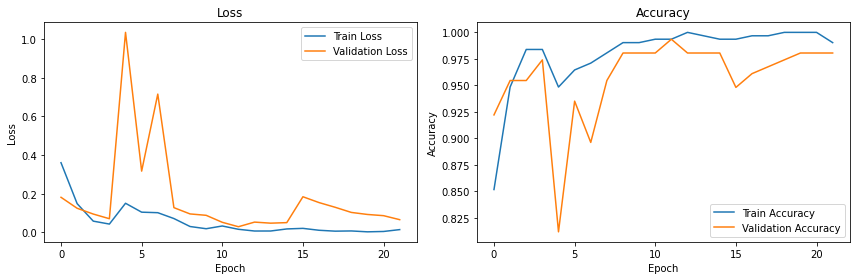

Micro F1-Score: 0.9827586206896551
Macro F1-Score: 0.9685295713510581
              precision    recall  f1-score   support

      BADPCB       1.00      0.98      0.99        49
     GOODPCB       0.90      1.00      0.95         9

    accuracy                           0.98        58
   macro avg       0.95      0.99      0.97        58
weighted avg       0.98      0.98      0.98        58



In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report

# Loss 그래프 그리기
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 테스트 데이터셋에 대한 예측
y_pred = load_model.predict(test_images)
y_pred = (y_pred > 0.5).astype(int)

# F1-score 계산 및 출력
f1_micro = f1_score(test_labels, y_pred, average='micro')
f1_macro = f1_score(test_labels, y_pred, average='macro')
print("Micro F1-Score:", f1_micro)
print("Macro F1-Score:", f1_macro)

# 클래스별 precision, recall, f1-score 출력
class_report = classification_report(test_labels, y_pred, target_names=class_names)
print(class_report)

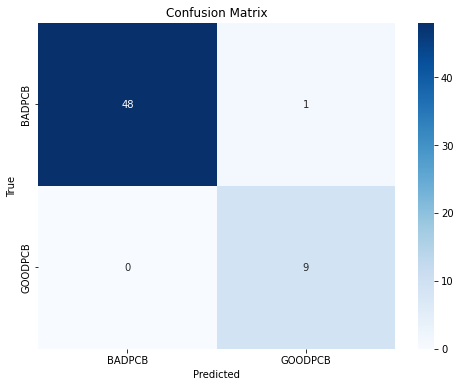

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 혼동 행렬 생성
confusion_mtx = confusion_matrix(test_labels, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

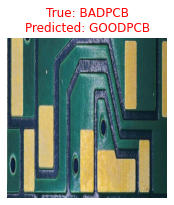

In [21]:
# 테스트 데이터셋에서 예측이 잘못된 이미지 확인
y_pred_classes = y_pred.flatten()
incorrect_predictions = np.where(y_pred_classes != test_labels)[0]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(incorrect_predictions[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[idx] / 255.0)
    true_label = class_names[test_labels[idx]]
    predicted_label = class_names[y_pred_classes[idx]]
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()